# R252 Deep Learning Project
## Implicit Bias of Gradient Descent

This project aims to look at the implicit bias of gradient descent, in particular through experiments with wide two-layer neural networks. The project aims to reproduce the paper by Chizat and Bach, 'Implicit Bias of Gradient Descent for Wide Two-Layer Neural Networks Trained with the Logistic Loss'. 

The main contributions of the paper are as follows: 


The first half of this project is to aim to recreate and verify the results that have been explored in the paper. 
The second half of this project will find different avenues to explore to extend upon the simple experiments they have carried out and to see if another further conclusions could be drawn from the investigation. 

### Setting

In this project, the following parameters will be used, and unless stated otherwise, the default value of that parameter will be used. 
- $m$: number of neurons, default value: $500$
- $n$: number of training samples, default value: $100$
- $d$: dimension of input data, default value: $2$
- $k$: number of clusters per dimension, default value: $4$
- $t$: number of iterations when training

In [1]:
using PyPlot, ProgressMeter
using LinearAlgebra, Random, Statistics

In [2]:
"""
Gradient ascent to train a 2-layers ReLU neural net for the soft-min loss
INPUT: X (training input), Y (training output), m (nb neurons), both: training both layers or just the output
OUTPUT: Ws (training trajectory)
"""
function twonet(X, Y, m, stepsize, niter; both=true, activation_function=relu_act) 
    (n,d) = size(X)
    W_init = randn(m, d+1)
    if !both
        W_init[:,end] .= 0
    end

    W     = copy(W_init)
    Ws    = zeros(m, d+1, niter) # store optimization path
    loss  = zeros(niter)
    margins = zeros(niter)
    betas = zeros(niter)

    for iter = 1:niter
        Ws[:,:,iter] = W
        act_input = W[:,1:end-1] * X'
        act = activation_function.(act_input) # (size m × n)
        # act  =  max.( W[:,1:end-1] * X', 0.0) 
        out  =  (1/m) * sum( W[:,end] .* act , dims=1) # (size 1 × n)
        perf = Y .* out[:]
        margin = minimum(perf)
        temp = exp.(margin .- perf) # stabilization
        gradR = temp .* Y ./ sum(temp)' # size n
        grad_w1 = (W[:,end] .* float.(act .> 0) * ( X .* gradR  ))  # (size m × d) 
        grad_w2 = act * gradR  # size m
        
        if both
            grad = cat(grad_w1, grad_w2, dims=2) # size (m × d+1)
            betas[iter] = sum(W.^2)/m
            loss[iter] = margin - log(sum(exp.(margin .- perf))/n)
            margins[iter] = margin/betas[iter]
            W = W + stepsize * grad/(sqrt(iter+1))
            
         else 
            grad = cat(zeros(m,d), grad_w2, dims=2) # size (m × d+1)
            betas[iter] = maximum([1,sqrt(sum(W[:,end].^2)/m)])
            loss[iter] = margin - log(sum(exp.(margin .- perf))/n)
            margins[iter] = margin/(sqrt(sum(W[:,end].^2))/m)
            W = W + betas[iter] * stepsize * grad /(sqrt(iter+1))
        end
    end
    Ws, loss, margins, betas
end

twonet

In [3]:
"Coordinates of the 2d cluster centers, p is k^2 the number of clusters"
function cluster_center(p,k)
    p1 = mod.(p .- 1,k) .+ 1
    p2 = div.(p .- 1,k) .+ 1
    Delta = 1/(3k-1)
    x1 =  Delta*(1 .+ 3*(p1 .- 1)) .- 1/2
    x2 =  Delta*(1 .+ 3*(p2 .- 1)) .- 1/2
    return x1,x2
end

cluster_center

In [4]:
"Train a two-layer neural network, by default both layers are trained, but option to train a single layer only"
function train_network(k, n, m, t; stepsize=0.5, both=true, activation_function=relu_act)
    # data distribution
    sd = 0 # number of spurious dimensions
    Delta = 1/(3k-1) # interclass distance
    A = ones(k^2) # cluster affectation
    A[randperm(k^2)[1:div(k^2,2)]] .= -1

    # sample from it
    P = rand(1:k^2,n) # cluster label
    T = 2π*rand(n)  # shift angle
    R = Delta*rand(n) # shift magnitude
    X = cat(ones(n), cluster_center(P,k)[1] .+ R .* cos.(T),cluster_center(P,k)[2] + R .* sin.(T), (rand(n,sd) .- 1/2), dims=2)
    Y = A[P]

    Ws, loss, margins, betas = twonet(X, Y, m, stepsize, t; both=both, activation_function=activation_function)
    return X, Y, Ws, loss, margins, betas
end

function get_X_Y(k, n; d=3)
    # data distribution 
    sd = d-3
    Delta = 1/(3k-1)
    A = ones(k^2) 
    A[randperm(k^2)[1:div(k^2,2)]] .= -1 # cluster affectation
    
    # sample from it
    P = rand(1:k^2,n)
    T = 2π*rand(n)
    R = Delta*rand(n)
    X = cat(ones(n),
            cluster_center(P,k)[1] .+ R .* cos.(T), 
            cluster_center(P,k)[2] + R .* sin.(T), 
            rand(n,sd) .- 1/2,
            dims=2)
    Y = A[P]
    return X,Y
end

function train_network_given_X_Y(X, Y, m, t; stepsize=0.5, both=true, activation_function=relu_act)
    Ws, loss, margins, betas = twonet(X, Y, m, stepsize, t; both=both, activation_function=activation_function)
    return Ws, loss, margins, betas
end

function train_network_both_single(k, n, m, t; stepsize=0.5, activation_function=relu_act)
    X, Y = get_X_Y(k, n)
    Ws_single, loss_single, margins_single, betas_single = train_network_given_X_Y(X, y, m, t; both=false, activation_function=activation_function)
    Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X, y, m, t; both=true, activation_function=activation_function)
    return X, Y, Ws_single, loss_single, margins_single, betas_single, Ws_both, loss_both, margins_both, betas_both
end

train_network_both_single (generic function with 1 method)

In [5]:
function plot_data(X, Y, k; save_flag=false, name="data_plot")
    X1 = X[(Y .== 1),:]
    X2 = X[(Y .== -1),:]
    # figure(figsize=[2.5,2.5])
    p = plot(X1[:,2],X1[:,3],"+r")
    plot(X2[:,2],X2[:,3],"_b")
    plot(cluster_center(1:k^2,k)[1],cluster_center(1:k^2,k)[2],"ok")
    axis("equal");axis("off");
    # axis("equal");
    xticks([], []); yticks([], [])
    if save_flag
        savefig(name * ".pdf",bbox_inches="tight")
    end
    return p
end

plot_data (generic function with 1 method)

In [6]:
function plot_margins(X, Y, Ws; save_flag=false, name="margin_plot")
    X1 = X[(Y .== 1),:]
    X2 = X[(Y .== -1),:]
    # figure(figsize=[2.5,2.5])
    f(x1, x2, t) = (1/m) * sum( Ws[:,end,t] .* max.( Ws[:,1:3,t] * [1;x1;x2], 0.0)) # (size 1 × n) # final prediction after training using the weights from after step t
    xs = -0.8:0.01:0.8
    tab1 = [f(xs[i],xs[j],size(Ws,3)) for i=1:length(xs), j=1:length(xs)]
    p = pcolormesh(xs', xs, tanh.(1000*tab1'),cmap="coolwarm",shading="gouraud",vmin=-1.0,vmax=1.0,edgecolor="face")
    xs = -0.8:0.005:0.8
    tab1 = [f(xs[i],xs[j],size(Ws,3)) for i=1:length(xs), j=1:length(xs)]
    contour(xs', xs, tanh.(1000*tab1'),levels =0, colors="k",antialiased = true,linewidths=2)
    plot(X1[:,2],X1[:,3],"+k")
    plot(X2[:,2],X2[:,3],"_k")
    axis("equal");axis("off");
    # axis("equal");
    if save_flag
        savefig(name * "_margins.pdf",bbox_inches="tight")
    end
    return p
end 

plot_margins (generic function with 1 method)

In [ ]:
k = 4
n = 100
m = 500
t = 20
save = true

X, Y, Ws_single, loss_single, margins_single, betas_single = train_network(k, n, m, t; stepsize=0.5, both=false)
Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X, Y, m, t; stepsize=0.5, both=true)

## Plot data distribution

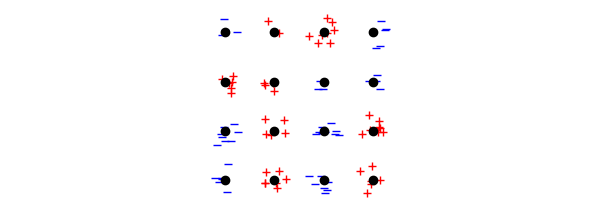

In [34]:
PyPlot.clf()
p1 = plot_data(X, Y, k; save_flag=true, name="data_dist_1")
gcf()

## Plot single layer margins 


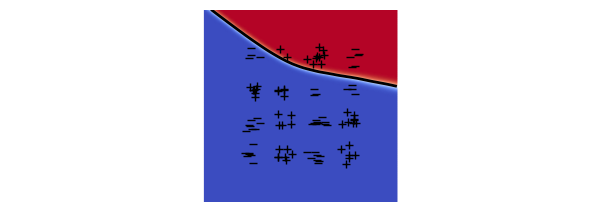

In [35]:
PyPlot.clf()
p2 = plot_margins(X, Y, Ws_single; save_flag=true, name="single")
gcf()

## Plot double layer margins

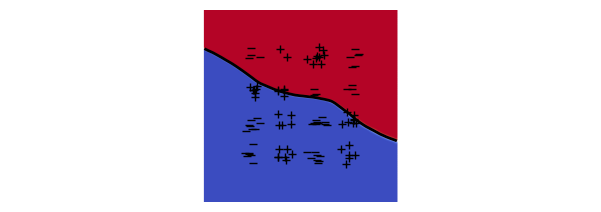

In [36]:
PyPlot.clf()
p3 = plot_margins(X, Y, Ws_both; save_flag=true, name="both")
gcf()

## Plot all together

In [36]:
function plot_dist_and_margins(k, n, m, t, save_name; save_flag=save, activation_function=relu_act)
    X, Y, Ws_single, loss_single, margins_single, betas_single = train_network(k, n, m, t; stepsize=0.5, both=false, activation_function=activation_function)
    Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X, Y, m, t; stepsize=0.5, both=true, activation_function=activation_function)

    PyPlot.clf()
    fig = figure("data dist and margins",figsize=(7.5,2.5))
    # fig = figure("data dist and margins")

    subplot(131)
    p1 = plot_data(X, Y, k; save_flag=false, name="data_dist_1")
    # axis("equal");axis("off")
    PyPlot.title("data dist")

    subplot(132)
    p2 = plot_margins(X, Y, Ws_single; save_flag=false, name="single")
    # axis("equal");axis("off")
    PyPlot.title("Margins Single")

    subplot(133)
    p3 = plot_margins(X, Y, Ws_both; save_flag=false, name="both")
    # axis("equal");axis("off")
    PyPlot.title("Margins Double")
    PyPlot.suptitle("", y=1.12)
    if save_flag
        savefig(save_name * ".pdf", bbox_inches="tight")
    end
    return fig
end
    

plot_dist_and_margins (generic function with 1 method)

In [44]:
function plot_dist_and_margins_given_X_Y(X, Y, k, n, m, t, save_name; save_flag=save, activation_function=relu_act)
    Ws_single, loss_single, margins_single, betas_single = train_network_given_X_Y(X, Y, m, t; stepsize=0.5, both=false, activation_function=activation_function)
    Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X, Y, m, t; stepsize=0.5, both=true, activation_function=activation_function)

    PyPlot.clf()
    fig = figure("data dist and margins",figsize=(7.5,2.5))
    # fig = figure("data dist and margins")

    subplot(131)
    p1 = plot_data(X, Y, k; save_flag=false, name="data_dist_1")
    # axis("equal");axis("off")
    PyPlot.title("data dist")

    subplot(132)
    p2 = plot_margins(X, Y, Ws_single; save_flag=false, name="single")
    # axis("equal");axis("off")
    PyPlot.title("Margins Single")

    subplot(133)
    p3 = plot_margins(X, Y, Ws_both; save_flag=false, name="both")
    # axis("equal");axis("off")
    PyPlot.title("Margins Double")
    # PyPlot.suptitle("", y=1.12)
    if save_flag
        savefig(save_name * ".pdf", bbox_inches="tight")
    end
    return fig
end
    

plot_dist_and_margins_given_X_Y (generic function with 1 method)

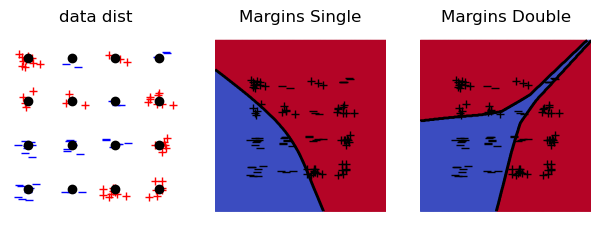

In [40]:
plot_dist_and_margins(4, 100, 500, 1000, "data and margin"; save_flag=true)
gcf()

### Recreate Figure 1 - Multiple Experiments of Plotting Data and Margins

In [83]:
function plot_data_margins_multiple_dists(k, n, m, niter, repeats; save_flag=false, save_name="dist_and_margins", activation_function=relu_act)
    PyPlot.clf()
    fig = figure("data dist and margins")
    fig.set_figheight(10)
    fig.set_figwidth(10)
    for i in 1:repeats
        X, Y = get_X_Y(k, n)
        Ws_single, loss_single, margins_single, betas_single = train_network_given_X_Y(X, Y, m, niter; stepsize=0.5, both=false, activation_function=activation_function)
        Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X, Y, m, niter; stepsize=0.5, both=true, activation_function=activation_function)

        subplot(repeats, 3, (3*i)-2)
        p1 = plot_data(X, Y, k; save_flag=false, name="data_dist_1")
        # axis("equal");axis("off")
        PyPlot.title("Data Dist")

        subplot(repeats, 3, (3*i)-1)
        p2 = plot_margins(X, Y, Ws_single; save_flag=false, name="single")
        # axis("equal");axis("off")
        PyPlot.title("Margins Single")

        subplot(repeats, 3, (3*i))
        p3 = plot_margins(X, Y, Ws_both; save_flag=false, name="single")
        # axis("equal");axis("off")
        PyPlot.title("Margins Both")
    end

    if save_flag
        savefig("diagrams/" * save_name * ".pdf", bbox_inches="tight")
    end
end

plot_data_margins_multiple_dists (generic function with 1 method)

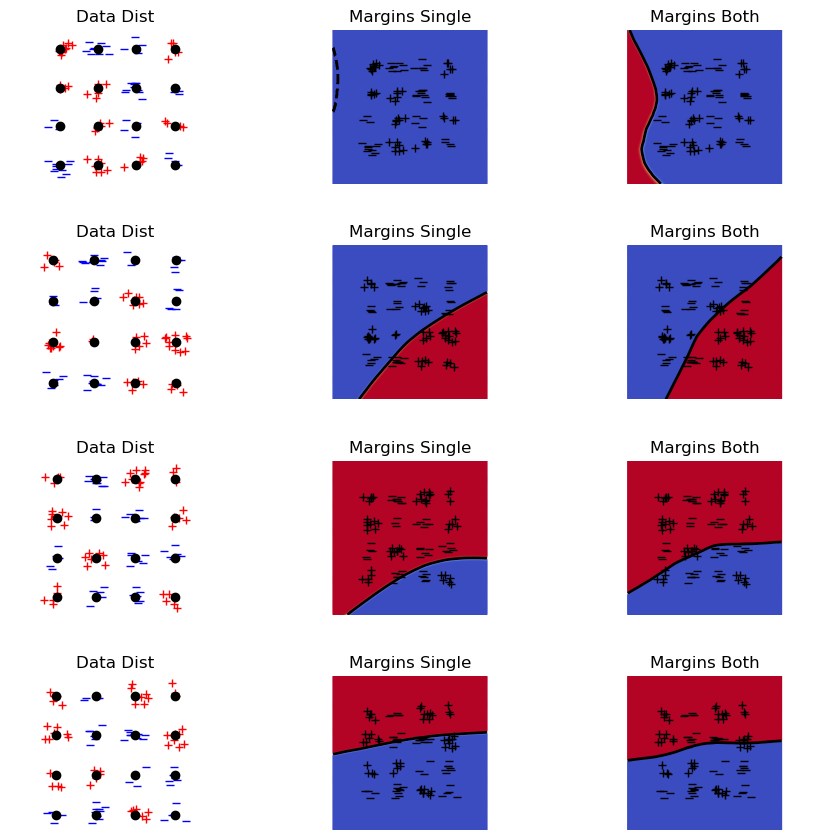

In [84]:
k = 4
n = 100
m = 500
niter = 20
repeats = 4
save = false

plot_data_margins_multiple_dists(k, n, m, niter, repeats; save_flag=save, save_name="dist_and_margins", activation_function=relu_act)
gcf()

## Testing the Network

In [8]:
function train_and_test_model(X_train, Y_train, X_test, Y_test, n_train, m, k, d, n_test, niter, stepsize, both_flag; activation_function=relu_act)
    # train network
    Ws, loss, margins, betas = twonet(X_train[1:n_train, :], Y_train[1:n_train, :], m, stepsize, niter; both=both_flag, activation_function=activation_function)
    # predict test set 
    preds = (1/m) * sum(Ws[:,end,end] .* max.( Ws[:,1:end-1,end] * X_test', 0.0), dims = 1) 
    # probability of error 
    loss = sum((Y_test .* preds') .< 0)/n_test # probability of error
    GC.gc()
    max_margin = maximum(margins)
    return loss, max_margin
end

train_and_test_model (generic function with 1 method)

### Experiment 0 - Test error as 

### Experiment 1 - Performance As n Increases

In [9]:
function experiment_ns(d, k, m, niter, stepsize, n_trains, n_test; both_layers=[true, false], repeats=1, activation_function=relu_act)
    loss_single = zeros(repeats, 1, length(n_trains), 1) # (repeats, no of ds, no of ns, no of ms)
    loss_both = zeros(repeats, 1, length(n_trains), 1) # (repeats, no of ds, no of ns, no of ms)
    max_margin_single = zeros(repeats, 1, length(n_trains), 1) # (repeats, no of ds, no of ns, no of ms)
    max_margin_both = zeros(repeats, 1, length(n_trains), 1) # (repeats, no of ds, no of ns, no of ms)
    loss_arrays = [loss_both, loss_single]
    max_margins_arrays = [max_margin_both, max_margin_single]
    X_test, Y_test = get_X_Y(k, n_test; d=d)
    for repeat in 1:repeats
        X_train, Y_train = get_X_Y(k, maximum(n_trains); d=d)
        p = Progress(length(loss_both))
        for i in 1:length(n_trains)
            n_train = n_trains[i]
            for (both, loss_array, max_margin_array) in zip(both_layers, loss_arrays, max_margins_arrays)
                loss, max_margin = train_and_test_model(X_train, Y_train, 
                                    X_test, Y_test, 
                                    n_train, m, k, d, 
                                    n_test, niter, 
                                    stepsize, both; activation_function=activation_function)
    
                loss_array[repeat,1,i,1] = loss
                max_margin_array[repeat,1,i,1] = max_margin
                next!(p)
            end
        end
    end
    # return the latest X, Y distribution
    return X_test, Y_test, loss_single, loss_both, max_margin_single, max_margin_both
end

experiment_ns (generic function with 1 method)

In [ ]:
d = 15
k = 3
m = 1000
niter = 5
stepsize = 0.5
n_trains = [32,64,128,256,512]
n_test = 4000
repeats = 20
save_name = "experiment_ns"
save_flag = false

X_test, Y_test, loss_single, loss_both, max_margin_single, max_margin_both = experiment_ns(d, k, m, niter, stepsize, n_trains, n_test; repeats=repeats)

In [80]:
using DelimitedFiles

writedlm("experiment_ns_loss_both.csv", loss_both, ',')
writedlm("experiment_ns_max_margin_single.csv", max_margin_single, ',')
writedlm("experiment_ns_max_margin_both.csv", max_margin_both, ',')

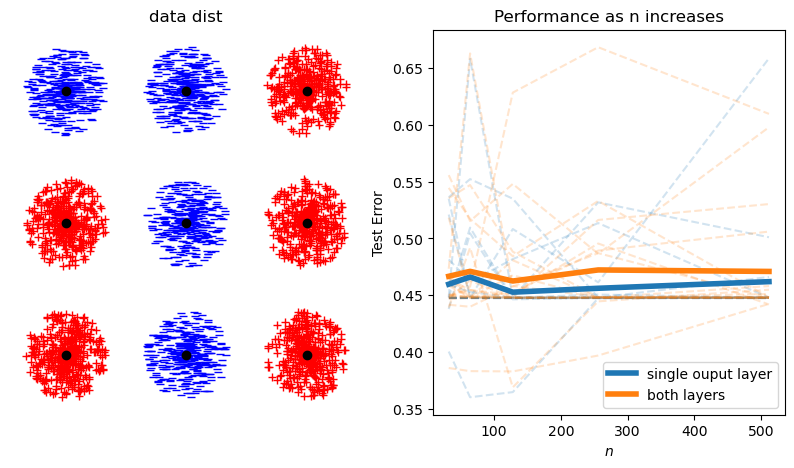

In [47]:
PyPlot.clf()
tight_layout()
fig = PyPlot.figure("experiment_ns", figsize=(10,5))

subplot(121)
p1 = plot_data(X_test, Y_test, k; save_flag=false, name="experiment_ns_data_dist")
axis("tight")
PyPlot.title("data dist")

subplot(122)
plot(n_trains, loss_single[:, 1, :, 1]', "C0--",alpha=0.2)
plot(n_trains, loss_both[:, 1, :, 1]', "C1--",alpha=0.2)
plot(n_trains, mean(loss_single[:,1,:,1], dims=1)[:], "C0", linewidth=4,label="single ouput layer")
plot(n_trains, mean(loss_both[:,1,:,1], dims=1)[:], "C1", linewidth=4,label="both layers")
axis("tight")
PyPlot.title("Performance as n increases")
PyPlot.xlabel(L"n", fontsize=10)
PyPlot.ylabel("Test Error", fontsize=10)
PyPlot.legend();

PyPlot.suptitle("", y=1.12)
if save_flag
    savefig(save_name * ".pdf", bbox_inches="tight")
end
gcf()

### Experiment 2 - Performance As d Increases

In [10]:
function experiment_ds(ds, k, m, niter, stepsize, n_train, n_test; both_layers=[true, false], repeats=1, activation_function=relu_act)
    loss_single = zeros(repeats, length(ds), 1, 1) # (repeats, no of ds, no of ns, no of ms)
    loss_both = zeros(repeats, length(ds), 1, 1) # (repeats, no of ds, no of ns, no of ms)
    max_margin_single = zeros(repeats, length(ds), 1, 1) # (repeats, no of ds, no of ns, no of ms)
    max_margin_both = zeros(repeats, length(ds), 1, 1) # (repeats, no of ds, no of ns, no of ms)
    loss_arrays = [loss_both, loss_single]
    max_margins_arrays = [max_margin_both, max_margin_single]
    
    for repeat in 1:repeats
        p = Progress(length(loss_both))
        for i in 1:length(ds)
            d = ds[i]
            X_test, Y_test = get_X_Y(k, n_test; d=d)
            X_train, Y_train = get_X_Y(k, n_train; d=d)
            for (both, loss_array, max_margin_array) in zip(both_layers, loss_arrays, max_margins_arrays)
                loss, max_margin = train_and_test_model(X_train, Y_train, 
                                    X_test, Y_test, 
                                    n_train, m, k, d, 
                                    n_test, niter, 
                                    stepsize, both; activation_function=activation_function)
    
                loss_array[repeat,i,1,1] = loss
                max_margin_array[repeat,i,1,1] = max_margin
                next!(p)
            end
        end
    end
    # return the latest X, Y distribution
    return X_test, Y_test, loss_single, loss_both, max_margin_single, max_margin_both
end

experiment_ds (generic function with 1 method)

In [50]:
ds = [5, 10, 15, 20, 25]
k = 4
m = 500
niter = 1000
stepsize = 0.5
n_train = 256
n_test = 100
repeats = 1
save_name = "experiment_ds"
save_flag = false

X_test, Y_test, loss_single, loss_both, max_margin_single, max_margin_both = experiment_ds(ds, k, m, niter, stepsize, n_train, n_test; repeats=repeats)

Progress:  40%|█████████████████                        |  ETA: 0:00:07

Progress:  60%|█████████████████████████                |  ETA: 0:00:05

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


([1.0 -0.049567414839292404 … -0.20272746711464007 0.3998569096306195; 1.0 0.32999140007166095 … -0.03966823089252325 -0.42127067350588754; … ; 1.0 -0.012530492851928088 … 0.43057486747025364 -0.07980280487744484; 1.0 0.32432555791352324 … -0.4234527002987428 0.4553745114364709], [-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0  …  1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0], [0.63 0.36 … 0.84 0.48;;;;], [0.62 0.38 … 0.82 0.42;;;;], [NaN NaN … NaN NaN;;;;], [-0.005414882383631429 -0.009018705615464724 … -0.006043790389923771 -0.004088613816285378;;;;])

In [ ]:
PyPlot.clf()
tight_layout()
fig = PyPlot.figure("experiment_ds", figsize=(10,5))

subplot(121)
p1 = plot_data(X_test, Y_test, k; save_flag=false, name="experiment_ds_data_dist")
axis("tight")
PyPlot.title("data dist")

subplot(122)
plot(ds, loss_single[:, :, 1, 1]', "C0--",alpha=0.2)
plot(ds, loss_both[:, :, 1, 1]', "C1--",alpha=0.2)
plot(ds, mean(loss_single[:, :, 1, 1], dims=1)[:], "C0", linewidth=4,label="single ouput layer")
plot(ds, mean(loss_both[:, :, 1, 1], dims=1)[:], "C1", linewidth=4,label="both layers")
axis("tight")
PyPlot.title("Performance as d increases")
PyPlot.xlabel(L"d", fontsize=15)
PyPlot.ylabel("Test Error", fontsize=15)

PyPlot.suptitle("", y=1.12)
if save_flag
    savefig(save_name * ".pdf", bbox_inches="tight")
end
gcf()

### Experiment 3 - Performance As m Increases

In [11]:
function experiment_ms(d, k, ms, niter, stepsize, n_train, n_test; both_layers=[true, false], repeats=1, activation_function=relu_act)
    loss_single = zeros(repeats, 1, 1, length(ms)) # (repeats, no of ds, no of ns, no of ms)
    loss_both = zeros(repeats, 1, 1, length(ms)) # (repeats, no of ds, no of ns, no of ms)
    max_margin_single = zeros(repeats, 1, 1, length(ms)) # (repeats, no of ds, no of ns, no of ms)
    max_margin_both = zeros(repeats, 1, 1, length(ms)) # (repeats, no of ds, no of ns, no of ms)
    loss_arrays = [loss_both, loss_single]
    max_margins_arrays = [max_margin_both, max_margin_single]
    X_test, Y_test = get_X_Y(k, n_test; d=d)
    X_train, Y_train = get_X_Y(k, n_train; d=d)
    for repeat in 1:repeats
        p = Progress(length(loss_both))
        for i in 1:length(ms)
            m = ms[i]
            for (both, loss_array, max_margin_array) in zip(both_layers, loss_arrays, max_margins_arrays)
                loss, max_margin = train_and_test_model(X_train, Y_train, 
                                    X_test, Y_test, 
                                    n_train, m, k, d, 
                                    n_test, niter, 
                                    stepsize, both; activation_function=activation_function)
    
                loss_array[repeat,1,1,i] = loss
                max_margin_array[repeat,1,1,i] = max_margin
                next!(p)
            end
        end
    end
    # return the latest X, Y distribution
    return X_test, Y_test, loss_single, loss_both, max_margin_single, max_margin_both
end

experiment_ms (generic function with 1 method)

In [55]:
d = 15
k = 4
ms = [8,16,32,64,128,256,512,1024]
niter = 1
stepsize = 0.5
n_train = 256
n_test = 500
repeats = 1
save_name = "experiment_ms"
save_flag = false

X_test, Y_test, loss_single, loss_both, max_margin_single, max_margin_both = experiment_ms(d, k, ms, niter, stepsize, n_train, n_test; repeats=repeats)




Progress:  25%|███████████                              |  ETA: 0:00:01

Progress:  50%|█████████████████████                    |  ETA: 0:00:00

Progress:  75%|███████████████████████████████          |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


([1.0 -0.1628406809903556 … 0.18202259971067425 -0.2933535938919153; 1.0 0.06189789381660088 … 0.2898492980132322 0.22845299483356518; … ; 1.0 -0.14216239400308775 … -0.016026316736378887 0.017466486527130454; 1.0 -0.11872399779438807 … 0.48606199371428926 0.2036063229863151], [-1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0  …  1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0], [0.0;;;; 0.0;;;; 0.0;;;; 0.0;;;; 0.0;;;; 0.0;;;; 0.0;;;; 0.0], [0.546;;;; 0.474;;;; 0.378;;;; 0.554;;;; 0.69;;;; 0.506;;;; 0.51;;;; 0.512], [NaN;;;; NaN;;;; NaN;;;; NaN;;;; NaN;;;; NaN;;;; NaN;;;; NaN], [-0.04057831195620328;;;; -0.022222855418040144;;;; -0.023560635402748;;;; -0.016133053942404846;;;; -0.01070507761322353;;;; -0.009457078568614606;;;; -0.005589159050855343;;;; -0.005567166416660014])

In [ ]:
using DelimitedFiles
writedlm("experiment_ms_X_test.csv", X_test, ',')
writedlm("experiment_ms_Y_test.csv", Y_test, ',')
writedlm("experiment_ms_loss_single.csv", loss_both, ',')
writedlm("experiment_ms_loss_both.csv", loss_both, ',')
writedlm("experiment_ms_max_margin_single.csv", max_margin_single, ',')
writedlm("experiment_ms_max_margin_both.csv", max_margin_both, ',')

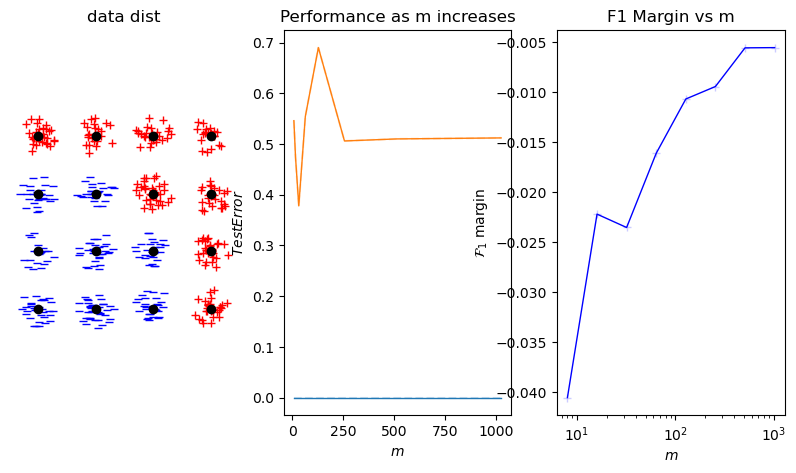

In [56]:
PyPlot.clf()
PyPlot.tight_layout()
subplots_adjust(wspace=0.5)
fig = PyPlot.figure("experiment_ms", figsize=(10,5))

subplot(131)
p1 = plot_data(X_test, Y_test, k; save_flag=false, name="experiment_ms_data_dist")

PyPlot.title("data dist")

subplot(132)
plot(ms, loss_single[:, 1, 1, :]', "C0--",alpha=0.2)
plot(ms, loss_both[:, 1, 1, :]', "C1--",alpha=0.2)
plot(ms, mean(loss_single[:, 1, 1, :], dims=1)[:], "C0", linewidth=1,label="single ouput layer")
plot(ms, mean(loss_both[:, 1, 1, :], dims=1)[:], "C1", linewidth=1,label="both layers")

PyPlot.title("Performance as m increases")
PyPlot.xlabel(L"m", fontsize=10)
PyPlot.ylabel(L"Test Error", fontsize=10)

subplot(133)
semilogx(ms,max_margin_single[:,1,1,:]', "+r", alpha=0.2, label="single output layer");
semilogx(ms,max_margin_both[:,1,1,:]', "+b", alpha=0.2, label="both output layer");
semilogx(ms,sum(max_margin_single[:,1,1,:],dims=1)[:]/repeats,linewidth=1,"r");
semilogx(ms,sum(max_margin_both[:,1,1,:],dims=1)[:]/repeats,linewidth=1,"b");

PyPlot.title("F1 Margin vs m")
PyPlot.xlabel(L"m", fontsize=10)
PyPlot.ylabel(L"$\mathcal{F}_1$ margin", fontsize=10)


PyPlot.suptitle("", y=1.12)
if save_flag
    savefig(save_name * ".pdf", bbox_inches="tight")
end
gcf()

## Experiment 4 - Change in Margins as niter increases

Dynamics of the classifier while training both layers for an initialization with a large
variance and a small initial step-size. The classifier first approaches the max-margin
classifier for the tangent kernel (Jacot et al., 2018) (c) and eventually converges to the
F1-max-margin (f).

In Figure 3, we illustrate for d = 2 a case where two
different kinds of implicit biases show up in a single dynamics (t is the number of iterations with a constant step-size). We initialize the ReLU network with a large variance (N(0; 402)).

In [12]:
function experiment_niters(d, k, m, niters, stepsize, n_train; both_layers=[true, false])
    X_train, Y_train = get_X_Y(k, n_train; d=d)
    weights_single = zeros(m, d+1, maximum(niters), length(niters)) # (m, d+1, the maximum number of iterations, how many niters that are being tried)
    weights_both = zeros(m, d+1, maximum(niters), length(niters)) # (m, d+1, the maximum number of iterations, how many niters that are being tried)
    weights_layers = [weights_single, weights_both]
    for i in 1:length(niters)
        for (both, weights_layer) in zip(both_layers, weights_layers)
            niter = niters[i]
            Ws, loss, margins, betas = train_network_given_X_Y(X_train, Y_train, m, niter; stepsize=stepsize, both=both)
            weights_layer[:, :, 1:niter, i] = Ws
        end
    end

    return X_train, Y_train, weights_single, weights_both
end

experiment_niters (generic function with 1 method)

In [ ]:
d = 43
k = 4
m = 1000
niters = [5, 10, 15, 20, 25]
n_train = 500
stepsize = 0.5

X_train, Y_train, weights_single, weights_both = experiment_niters(d, k, m, niters, stepsize, n_train; both_layers=[true, false])

In [14]:
function simple_plot_niters(d, k, m, niters, n_train, stepsize; save_flag=false, save_name=("experiment_niters_"*string(niters)), both_layers=[true, false])
    GC.gc()
    X_train, Y_train = get_X_Y(k, n_train; d=d)
    PyPlot.clf()
    plot_data(X_train, Y_train, k; save_flag=true)
    max_niter = maximum(niters)
    
    Ws_single, loss_single, margins_single, betas_single = train_network_given_X_Y(X_train, Y_train, m, max_niter; stepsize=stepsize, both=false)
    Ws_both, loss_both, margins_both, betas_both = train_network_given_X_Y(X_train, Y_train, m, max_niter; stepsize=stepsize, both=true)

    # single
    PyPlot.clf()
    tight_layout()
    fig = PyPlot.figure("experiment_niters_single", figsize=(20,5)) 
    for i in 1:length(niters)
        subplot_number = 100 + (10*length(niters)) + i
        subplot(subplot_number)
        niter = niters[i]
        p1 = plot_margins(X_train, Y_train, Ws_single[:, :, 1:niter])
        PyPlot.title("niter = " * string(niter))
        GC.gc()
    end
    if save_flag
        savefig(save_name * "_single.pdf", bbox_inches="tight")
    end

    # both
    PyPlot.clf()
    tight_layout()
    fig = PyPlot.figure("experiment_niters_both", figsize=(20,5)) 
    for i in 1:length(niters)
        subplot_number = 100 + (10*length(niters)) + i
        subplot(subplot_number)
        niter = niters[i]
        p1 = plot_margins(X_train, Y_train, Ws_both[:, :, 1:niter])
        PyPlot.title("niter = " * string(niter))
    end
    if save_flag
        savefig(save_name * "_both.pdf", bbox_inches="tight")
    end
end

simple_plot_niters (generic function with 1 method)

In [236]:
d = 15
k = 4
m = 1000
niters = [100, 500, 1000, 5000, 10000, 50000, 100000]
# niters = [1,2,3,4]
n_train = 256
stepsize = 0.5
save_flag = true 
for random_number in [20, 35, 7, 2, 101]
    Random.seed!(random_number)
    save_name = "diagrams/experiment_niters_repeat4_" * string(niters) * "d_" * string(d) * "rand_" * string(random_number)
    simple_plot_niters(d, k, m, niters, n_train, stepsize; save_flag=save_flag, save_name=save_name)
    GC.gc()
end

## Extension

### Experiment Activations

#### ReLU

In [26]:
function relu_act(x)
    return max(x, 0)
end

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\Kevalee Shah\.julia\packages\PyCall\L0fLP\src\numpy.jl:67
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.


relu_act (generic function with 1 method)

#### ELU

In [27]:
function elu_act(x; a=0.1)
    if x<0
        return a*(exp(x)-1)
    else
        return x
    end
end

elu_act (generic function with 1 method)

#### Leaky ReLU

In [28]:
function leaky_relu_act(x)
    if x<0
        return 0.01*x
    else
        return x
    end
end

leaky_relu_act (generic function with 1 method)

#### Sigmoid

In [29]:
function sigmoid_act(x)
    return 1/(1+exp(-x))
end

sigmoid_act (generic function with 1 method)

#### Tanh

In [34]:
function tanh_act(x)
    return (2 * sigmoid_act(2*x)) - 1
end

sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.
sys:1: UserWarning: No contour levels were found within the data range.


tanh_act (generic function with 1 method)

### Swish

In [31]:
function swish_act(x)
    return x*sigmoid_act(x)
end

swish_act (generic function with 1 method)

In [50]:
activation_functions = [relu_act, elu_act, leaky_relu_act, sigmoid_act, tanh_act, swish_act]
activation_function_names = ["relu", "elu", "leaky_relu", "sigmoid", "tanh", "swish"]
k = 4
n = 200
m = 500
t = 50000
save = true
X, Y = get_X_Y(k,n)

for (act_function, act_name) in zip(activation_functions, activation_function_names)
    name = "diagrams/dist_and_margings_" * string(k) * "_" * string(n) * "_" * string(m) * "_" * string(t) * "_" * act_name
    plot_dist_and_margins_given_X_Y(X, Y, k, n, m, t, name; save_flag=save, activation_function=act_function)
    GC.gc()
end